# Clustering analysis of PubTrends output

Analyze different versions of clustering


In [1]:
import gzip
import json
import logging
import os

from bokeh.plotting import output_notebook

from pysrc.config import PubtrendsConfig
from pysrc.papers.utils import SORT_MOST_CITED

SEARCH_SORT = SORT_MOST_CITED
SEARCH_PAPERS = 10_000

logging.basicConfig(level=logging.DEBUG, format='%(asctime)s %(levelname)s: %(message)s')
logger = logging.getLogger('notebook')

output_notebook()

%matplotlib inline
%config InlineBackend.figure_format='retina'

Loading BokehJS ...

2025-11-03 10:03:42,545 DEBUG: CACHEDIR=/Users/Oleg.Shpynov/.matplotlib
2025-11-03 10:03:42,547 DEBUG: Using fontManager instance from /Users/Oleg.Shpynov/.matplotlib/fontlist-v390.json
2025-11-03 10:03:42,693 DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-11-03 10:03:42,694 DEBUG: Loaded backend inline version unknown.


# Load data

In [2]:
from pysrc.papers.data import AnalysisData

path_data = os.path.expanduser('~/Downloads/pubmed-immune-system-aging.json.gz')
# path_data = os.path.expanduser('~/Downloads/pubmed-human-aging.json.gz')
# path_data = os.path.expanduser('~/Downloads/pubmed-human-aging-semantic.json.gz')
with gzip.open(path_data, 'r') as f:
    data = AnalysisData.from_json(json.loads(f.read().decode('utf-8')))
data

/Users/Oleg.Shpynov/miniconda3/envs/pubtrends/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


# Analysis - Phenograph algorithm (default)

In [3]:
from pysrc.papers.analysis.graph import build_papers_graph, similarity

config = PubtrendsConfig(test=False)

bibliographic_graph = build_papers_graph(
    data.df, data.cit_df, data.cocit_grouped_df, data.bibliographic_coupling_df,
)
logger.debug(f'Bibliographic edges/nodes={bibliographic_graph.number_of_edges() / bibliographic_graph.number_of_nodes()}')

2025-11-03 10:03:44,783 DEBUG: Bibliographic edges/nodes=18.61548556430446


In [4]:
from pysrc.papers.analysis.text import chunks_to_text_embeddings

papers_text_embeddings = chunks_to_text_embeddings(data.df, data.chunks_embeddings, data.chunks_idx)

In [5]:
from pysrc.papers.analysis.node2vec import node2vec
from pysrc.config import NODE2VEC_GRAPH_EDGES, GRAPH_TEXT_SIMILARITY_EDGES
from pysrc.papers.analysis.graph import sparse_graph, add_text_similarities_edges


logger.debug('Adding text similarities edges')
add_text_similarities_edges(data.df['id'], papers_text_embeddings, bibliographic_graph, GRAPH_TEXT_SIMILARITY_EDGES)
logger.debug(f'Bibliographic+text edges/nodes={bibliographic_graph.number_of_edges() / bibliographic_graph.number_of_nodes()}')

logger.debug('Prepare sparse graph of text + bibliographic edges for node2vec')
for i, j in bibliographic_graph.edges():
    bibliographic_graph[i][j]['similarity'] = similarity(bibliographic_graph.get_edge_data(i, j))
analysis_graph = sparse_graph(bibliographic_graph, NODE2VEC_GRAPH_EDGES)


2025-11-03 10:03:47,247 DEBUG: Adding text similarities edges
2025-11-03 10:03:47,542 DEBUG: Bibliographic+text edges/nodes=96.23359580052494
2025-11-03 10:03:47,542 DEBUG: Prepare sparse graph of text + bibliographic edges for node2vec
2025-11-03 10:03:47,592 DEBUG: Building 50-neighbours sparse graph, edges/nodes=96.23359580052494
2025-11-03 10:03:47,664 DEBUG: Sparse 50-neighbours graph edges/nodes=18.888451443569554


In [6]:
graph_embeddings = node2vec(
    data.df['id'],
    analysis_graph,
    key='similarity'
)

2025-11-03 10:03:47,673 DEBUG: Precomputing random walk probabilities
2025-11-03 10:03:47,676 DEBUG: Analyzed probabilities for 1 nodes
2025-11-03 10:03:47,901 DEBUG: Analyzed probabilities for 101 nodes
2025-11-03 10:03:48,119 DEBUG: Analyzed probabilities for 201 nodes
2025-11-03 10:03:48,293 DEBUG: Analyzed probabilities for 301 nodes
2025-11-03 10:03:48,466 DEBUG: Analyzed probabilities for 401 nodes
2025-11-03 10:03:48,597 DEBUG: Analyzed probabilities for 501 nodes
2025-11-03 10:03:48,695 DEBUG: Analyzed probabilities for 601 nodes
2025-11-03 10:03:48,761 DEBUG: Analyzed probabilities for 701 nodes
2025-11-03 10:03:48,788 DEBUG: Performing random walks
2025-11-03 10:03:48,789 DEBUG: Generating walk 1
2025-11-03 10:03:49,045 DEBUG: Generating walk 2
2025-11-03 10:03:49,296 DEBUG: Generating walk 3
2025-11-03 10:03:49,548 DEBUG: Generating walk 4
2025-11-03 10:03:49,811 DEBUG: Generating walk 5
2025-11-03 10:03:50,061 DEBUG: Generating walk 6
2025-11-03 10:03:50,305 DEBUG: Generati

In [7]:
from pysrc.papers.analysis.clustering import cluster_and_sort

data.clusters, data.dendrogram = cluster_and_sort(graph_embeddings, 10)
data.df['comp'] = data.clusters

2025-11-03 10:04:26,011 DEBUG: Looking for clusters=10
2025-11-03 10:04:26,019 DEBUG: Clusters = 10, min cluster size = 7
2025-11-03 10:04:26,019 DEBUG: Clusters sizes: Counter({0: 401, 6: 90, 3: 86, 2: 56, 7: 50, 4: 35, 8: 14, 5: 13, 1: 10, 9: 7})
2025-11-03 10:04:26,032 DEBUG: Reorder clusters by size descending


Cophenetic Correlation Coefficient: 0.25551778323933017, the closer to 1, the better hierarchical clustering


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from pysrc.config import PCA_VARIANCE

def update_coords(df, embeddings):
    pca = PCA(n_components=PCA_VARIANCE, svd_solver="full")
    pca_coords = pca.fit_transform(StandardScaler().fit_transform(embeddings))
    logger.debug('Apply transformation')
    tsne = TSNE(n_components=2, random_state=42, metric="cosine", perplexity=min(30, len(data.df) - 1))
    coords = tsne.fit_transform(pca_coords)
    df['x'] = coords[:, 0]
    df['y'] = coords[:, 1]

In [9]:
update_coords(data.df, graph_embeddings)

2025-11-03 10:04:26,063 DEBUG: Apply transformation


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
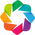

2025-11-03 10:04:27,674 DEBUG: Generating topics description, ignore_comp=None
2025-11-03 10:04:27,675 DEBUG: Compute average tokens counts per components
2025-11-03 10:04:27,722 DEBUG: Take frequent tokens that have the most descriptive frequency vector for topics
2025-11-03 10:04:27,724 DEBUG: Description
0: young:6.845,old:6.771,mouse:6.675,response:6.670,immune:6.529,elderly:6.468,expression:6.385,lymphocyte:6.346,active:6.267,increase:6.211,relate:6.055,functional:5.978,significant:5.972,group:5.891,decrease:5.882
1: dendritic:3.907,killer:3.827,macrophage:3.774,innate:3.765,nature:3.703,mature:3.485,marrow:3.238,monocyte:3.186,nkt:3.180,perforins:3.133,tnf:3.132,derive:3.009,dc:2.815,targeted:2.776,circulate:2.764
2: tcr:3.780,centenarians:3.662,transcription:3.541,dynamic:3.291,single:3.155,comprehensive:3.126,unique:3.122,supercentenarians:3.110,nave:3.072,signature:3.060,pro:3.001,transcriptome:2.993,sequence:2.921,insightful:2.872,state:2.864
3: il-17:3.623,th17:3.561,tregs:3

In [10]:
from pysrc.papers.plot.plotter import Plotter
from bokeh.io import show

plotter = Plotter(config, data)
show(plotter.plot_papers_graph(interactive=False))

## Other clustering

In [11]:
from pysrc.papers.analysis.clustering import reorder_by_size
from collections import Counter
from sklearn.cluster import HDBSCAN

def hdbscan(x):
    # Use metric="cosine" for high-dimensional sparse text/embeddings.
    hdb = HDBSCAN(min_cluster_size=10, metric="cosine")
    hdb.fit(x)
    labels = hdb.labels_
    clusters_counter = Counter(labels)
    logger.debug(f'Clusters sizes: {clusters_counter}')
    clusters = reorder_by_size(labels)
    return clusters, None


In [12]:
data.clusters, data.dendrogram = hdbscan(graph_embeddings)
data.df['comp'] = data.clusters
plotter = Plotter(config, data)
show(plotter.plot_papers_graph(interactive=False))

2025-11-03 10:04:28,039 DEBUG: Clusters sizes: Counter({-1: 652, 3: 18, 2: 18, 0: 17, 5: 16, 6: 16, 1: 15, 4: 10})
2025-11-03 10:04:28,039 DEBUG: Reorder clusters by size descending
2025-11-03 10:04:28,040 DEBUG: Generating topics description, ignore_comp=None
2025-11-03 10:04:28,041 DEBUG: Compute average tokens counts per components
2025-11-03 10:04:28,092 DEBUG: Take frequent tokens that have the most descriptive frequency vector for topics
2025-11-03 10:04:28,095 DEBUG: Description
0: immune:7.336,young:7.126,old:7.110,response:7.074,mouse:6.953,elderly:6.950,increase:6.839,expression:6.744,functional:6.614,active:6.583,cd4:6.580,relate:6.550,associate:6.500,lymphocyte:6.459,cd8:6.441
1: cd6:2.197,dth:2.115,vgamma9vdelta2:2.079,blast:1.954,samp1:1.814,tdth:1.792,mncs:1.740,il-3:1.711,allo:1.603,family:1.554,haplotype:1.527,footpad:1.527,amlr:1.491,hgg:1.386,tolerogen:1.386
2: gl183:2.433,eb6:2.204,nutrition:1.931,thymocyte:1.839,vascular:1.815,hdm:1.792,cd31:1.740,asthma:1.738,p<0.

## Other plots

In [13]:
# show(plotter.topics_hierarchy_with_keywords())
# show(plotter.plot_papers_by_year())
# show(plotter.plot_topic_years_distribution())
# show(plotter.plot_top_cited_papers())
# show(plotter.plot_most_cited_per_year_papers())
# show(plotter.plot_fastest_growth_per_year_papers())
# from pysrc.papers.analysis.text import get_frequent_tokens
# from itertools import chain
# freq_kwds = get_frequent_tokens(chain(*chain(*plotter.data.corpus)))
# show(plotter.plot_keywords_frequencies(freq_kwds))

# Analysis - combine text + graph embeddings

In [14]:
from pysrc.papers.utils import l2norm
from pysrc.papers.analysis.node2vec import node2vec
from pysrc.config import NODE2VEC_GRAPH_EDGES
from pysrc.papers.analysis.graph import sparse_graph

bibliographic_graph = build_papers_graph(
    data.df, data.cit_df, data.cocit_grouped_df, data.bibliographic_coupling_df,
)
logger.debug(f'Bibliographic edges/nodes={bibliographic_graph.number_of_edges() / bibliographic_graph.number_of_nodes()}')

for i, j, d in bibliographic_graph.edges(data=True):
    d['similarity'] = similarity(d)

logger.debug('Preparing sparse graph for embeddings')
node2vec_graph = sparse_graph(bibliographic_graph, NODE2VEC_GRAPH_EDGES)

logger.debug('Analyzing papers graph embeddings')
bibliographic_graph_embeddings = l2norm(node2vec(
    data.df['id'],
    node2vec_graph,
    'similarity'
))

2025-11-03 10:04:28,405 DEBUG: Bibliographic edges/nodes=18.61548556430446
2025-11-03 10:04:28,410 DEBUG: Preparing sparse graph for embeddings
2025-11-03 10:04:28,411 DEBUG: Building 50-neighbours sparse graph, edges/nodes=18.61548556430446
2025-11-03 10:04:28,447 DEBUG: Sparse 50-neighbours graph edges/nodes=10.221784776902886
2025-11-03 10:04:28,448 DEBUG: Analyzing papers graph embeddings
2025-11-03 10:04:28,448 DEBUG: Precomputing random walk probabilities
2025-11-03 10:04:28,451 DEBUG: Analyzed probabilities for 1 nodes
2025-11-03 10:04:28,659 DEBUG: Analyzed probabilities for 101 nodes
2025-11-03 10:04:28,799 DEBUG: Analyzed probabilities for 201 nodes
2025-11-03 10:04:28,901 DEBUG: Analyzed probabilities for 301 nodes
2025-11-03 10:04:28,976 DEBUG: Analyzed probabilities for 401 nodes
2025-11-03 10:04:29,003 DEBUG: Analyzed probabilities for 501 nodes
2025-11-03 10:04:29,009 DEBUG: Analyzed probabilities for 601 nodes
2025-11-03 10:04:29,011 DEBUG: Analyzed probabilities for 70

In [15]:
from pysrc.config import VISUALIZATION_GRAPH_EDGES

logger.debug('Adding text similarities edges')
add_text_similarities_edges(data.df['id'], papers_text_embeddings, bibliographic_graph, GRAPH_TEXT_SIMILARITY_EDGES)
logger.debug(f'Bibliographic+text edges/nodes='
             f'{bibliographic_graph.number_of_edges() / bibliographic_graph.number_of_nodes()}')
for i, j, d in bibliographic_graph.edges(data=True):
    d['similarity'] = similarity(d)
papers_graph = sparse_graph(bibliographic_graph, VISUALIZATION_GRAPH_EDGES)

2025-11-03 10:04:57,229 DEBUG: Adding text similarities edges
2025-11-03 10:04:57,524 DEBUG: Bibliographic+text edges/nodes=96.23359580052494
2025-11-03 10:04:57,555 DEBUG: Building 10-neighbours sparse graph, edges/nodes=96.23359580052494
2025-11-03 10:04:57,601 DEBUG: Sparse 10-neighbours graph edges/nodes=3.8871391076115485


# Graph only embeddings

In [16]:
papers_embeddings = bibliographic_graph_embeddings
data.clusters, data.dendrogram = cluster_and_sort(papers_embeddings, 10)
data.df['comp'] = data.clusters
update_coords(data.df, papers_embeddings)
plotter = Plotter(config, data)
show(plotter.plot_papers_graph(interactive=False))

2025-11-03 10:04:57,613 DEBUG: Looking for clusters=10
2025-11-03 10:04:57,622 DEBUG: Clusters = 10, min cluster size = 5
2025-11-03 10:04:57,622 DEBUG: Clusters sizes: Counter({0: 243, 7: 145, 4: 122, 2: 118, 9: 43, 1: 36, 5: 20, 3: 15, 6: 15, 8: 5})
2025-11-03 10:04:57,635 DEBUG: Reorder clusters by size descending
2025-11-03 10:04:57,643 DEBUG: Apply transformation


Cophenetic Correlation Coefficient: 0.8443516785626677, the closer to 1, the better hierarchical clustering


2025-11-03 10:04:58,492 DEBUG: Generating topics description, ignore_comp=None
2025-11-03 10:04:58,493 DEBUG: Compute average tokens counts per components
2025-11-03 10:04:58,530 DEBUG: Take frequent tokens that have the most descriptive frequency vector for topics
2025-11-03 10:04:58,532 DEBUG: Description
0: mouse:6.009,cd4:5.864,young:5.791,expression:5.784,old:5.664,il-2:5.657,production:5.623,increase:5.546,response:5.509,elderly:5.449,stimulate:5.208,cytokine:5.153,gamma:5.149,lymphocyte:5.140,memory:5.131
1: lymphocyte:3.293,abnormal:3.212,forming:3.103,immunology:3.094,thymuses:3.041,group:3.034,lymphoid:3.009,thymocyte:2.886,discusses:2.869,immunoglobulins:2.849,month:2.846,leukocyte:2.829,suppressor:2.825,involutes:2.787,syngeneic:2.768
2: monocyte:5.121,macrophage:4.629,killer:4.433,nature:4.342,mature:4.227,dendritic:4.195,derive:3.860,functional:3.601,innate:3.577,marrow:3.543,neutrophils:3.464,dc:3.446,subject:3.385,tumor:3.370,impairs:3.367
3: immune:4.755,vaccine:4.676,

# Clustering of text embeddings vs PCA on text embeddings

In [17]:
papers_embeddings = papers_text_embeddings
data.clusters, data.dendrogram = cluster_and_sort(papers_embeddings, 10)
data.df['comp'] = data.clusters
update_coords(data.df, papers_embeddings)
plotter = Plotter(config, data)
show(plotter.plot_papers_graph(interactive=False))

2025-11-03 10:04:58,797 DEBUG: Looking for clusters=10
2025-11-03 10:04:58,920 DEBUG: Clusters = 10, min cluster size = 1
2025-11-03 10:04:58,920 DEBUG: Clusters sizes: Counter({0: 750, 1: 3, 2: 2, 9: 1, 7: 1, 6: 1, 8: 1, 5: 1, 3: 1, 4: 1})
2025-11-03 10:04:59,076 DEBUG: Reorder clusters by size descending
2025-11-03 10:04:59,196 DEBUG: Apply transformation


Cophenetic Correlation Coefficient: 0.755655494522972, the closer to 1, the better hierarchical clustering


2025-11-03 10:05:00,088 DEBUG: Generating topics description, ignore_comp=None
2025-11-03 10:05:00,089 DEBUG: Compute average tokens counts per components
2025-11-03 10:05:00,126 DEBUG: Take frequent tokens that have the most descriptive frequency vector for topics
2025-11-03 10:05:00,128 DEBUG: Description
0: immune:7.347,young:7.144,old:7.123,response:7.090,elderly:6.973,mouse:6.964,increase:6.849,expression:6.755,functional:6.631,active:6.601,cd4:6.598,relate:6.562,associate:6.509,lymphocyte:6.474,cd8:6.468
1: solely:1.138,ask:0.777,scientist:0.777,immunologist:0.777,head:0.777,youngster:0.693,intimately:0.693,painful:0.693,stepchild:0.693,card:0.693,quiet:0.693,tackle:0.693,falter:0.693,bolster:0.693,hyperactive:0.693
2: gold:0.693,perspective:0.311,case:0.149,promote:0.103,longevity:0.097,immunology:0.031,systemic:0.029,old:0.006,immune:0.005,occurs:0.000,occurrence:0.000,occupy:0.000,occupancy:0.000,+0.7:0.000,occasion:0.000
3: recognition:0.336,variety:0.265,degree:0.166,accesso

In [18]:
from pysrc.config import NODE2VEC_EMBEDDINGS_VECTOR_LENGTH
from sklearn.preprocessing import normalize


# Try PCA on text embeddings - better for clustering
pca_papers_text_embeddings = PCA(n_components=NODE2VEC_EMBEDDINGS_VECTOR_LENGTH, svd_solver="full").fit_transform(
    normalize(papers_text_embeddings)
)
papers_embeddings = pca_papers_text_embeddings
data.clusters, data.dendrogram = cluster_and_sort(papers_embeddings, 10)
data.df['comp'] = data.clusters
update_coords(data.df, papers_embeddings)
plotter = Plotter(config, data)
show(plotter.plot_papers_graph(interactive=False))

2025-11-03 10:05:00,747 DEBUG: Looking for clusters=10
2025-11-03 10:05:00,756 DEBUG: Clusters = 10, min cluster size = 10
2025-11-03 10:05:00,756 DEBUG: Clusters sizes: Counter({7: 159, 0: 157, 5: 100, 2: 86, 9: 71, 1: 64, 3: 47, 4: 35, 6: 33, 8: 10})
2025-11-03 10:05:00,770 DEBUG: Reorder clusters by size descending
2025-11-03 10:05:00,778 DEBUG: Apply transformation


Cophenetic Correlation Coefficient: 0.2650408328386995, the closer to 1, the better hierarchical clustering


2025-11-03 10:05:01,647 DEBUG: Generating topics description, ignore_comp=None
2025-11-03 10:05:01,648 DEBUG: Compute average tokens counts per components
2025-11-03 10:05:01,687 DEBUG: Take frequent tokens that have the most descriptive frequency vector for topics
2025-11-03 10:05:01,689 DEBUG: Description
0: cytokine:4.900,functional:4.634,memory:4.621,cd4:4.576,increase:4.297,immune:4.264,adults:4.248,young:4.236,elderly:4.117,produce:3.964,il-4:3.959,change:3.955,cd8:3.943,expression:3.940,naive:3.896
1: mouse:4.700,cmv:4.609,monocyte:4.578,immune:4.239,showing:4.230,young:4.178,lymphocyte:4.169,old:4.160,modeling:4.135,level:4.133,associate:4.097,cd8:4.019,group:4.011,inflammatory:3.993,study:3.954
2: tcr:3.478,cd4(+:3.222,naive:3.106,patient:3.007,death:2.984,highly:2.978,count:2.964,thymic:2.877,hiv-1:2.834,cd4:2.808,susceptible:2.780,cd3:2.742,abcs:2.673,proportion:2.662,interleukin-2:2.651
3: hla:3.522,th17:3.081,recipient:3.031,senieur:3.030,woman:3.028,il-17:2.972,grafting:2

# Text and graph embeddings combined

In [19]:
import numpy as np

logger.debug('Computing aggregated graph and text embeddings for papers')
papers_embeddings = normalize(np.concatenate([normalize(bibliographic_graph_embeddings) * 2,
                                              normalize(pca_papers_text_embeddings) * 1], axis=1))
data.clusters, data.dendrogram = cluster_and_sort(papers_embeddings, 10)
data.df['comp'] = data.clusters
update_coords(data.df, papers_embeddings)
plotter = Plotter(config, data)
show(plotter.plot_papers_graph(interactive=False))

2025-11-03 10:05:01,984 DEBUG: Computing aggregated graph and text embeddings for papers
2025-11-03 10:05:01,986 DEBUG: Looking for clusters=10
2025-11-03 10:05:02,000 DEBUG: Clusters = 10, min cluster size = 5
2025-11-03 10:05:02,001 DEBUG: Clusters sizes: Counter({0: 190, 1: 166, 6: 146, 7: 145, 2: 62, 4: 19, 9: 17, 8: 6, 5: 6, 3: 5})
2025-11-03 10:05:02,025 DEBUG: Reorder clusters by size descending
2025-11-03 10:05:02,065 DEBUG: Apply transformation


Cophenetic Correlation Coefficient: 0.9010495136806297, the closer to 1, the better hierarchical clustering


2025-11-03 10:05:03,103 DEBUG: Generating topics description, ignore_comp=None
2025-11-03 10:05:03,104 DEBUG: Compute average tokens counts per components
2025-11-03 10:05:03,141 DEBUG: Take frequent tokens that have the most descriptive frequency vector for topics
2025-11-03 10:05:03,143 DEBUG: Description
0: monocyte:4.964,macrophage:4.813,impairs:4.623,functional:4.596,killer:4.447,nature:4.409,elderly:4.392,young:4.371,subject:4.315,number:4.295,level:4.291,increase:4.273,bone:4.199,expression:4.192,mature:4.173
1: immune:5.590,cd8:5.367,cmv:5.074,infected:4.908,specific:4.818,senescent:4.789,adults:4.723,patient:4.716,immunosenescent:4.664,cd4:4.579,inflammatory:4.506,include:4.461,disease:4.409,profile:4.380,tregs:4.375
2: il-2:5.486,production:5.277,gamma:4.959,cytokine:4.947,mouse:4.924,ifn:4.836,produce:4.734,il-4:4.602,stimulate:4.579,young:4.359,old:4.357,type:4.200,culture:4.170,cd3:4.061,generate:4.025
3: lymphocyte:3.636,immunology:3.348,thymuses:3.324,month:3.227,lymphoi

# END